In [2]:
import os
import pandas as pd

# 입력 파일 이름
input_file_name = './data/ucosmos-balance.csv'
#input_file_name = './data/ujuno-balance.csv'
#input_file_name = './data/ukava-balance.csv'
#input_file_name = './data/uosmo-balance.csv'

# 데이터셋 로드
df = pd.read_csv(input_file_name)

# '_time' 열을 datetime 형식으로 변환
df['_time'] = pd.to_datetime(df['_time'])

# Filter out rows where 'amountValue' is -1
df = df[df['amountValue'] != -1]

# Filter out moduleNames with less than 2000 amountValues
counts = df['moduleName'].value_counts()
df = df[df['moduleName'].isin(counts[counts >= 2000].index)]

# '2023-01-27T17:00:00Z' 이전의 데이터 필터링
data = df[df['_time'] >= '2023-01-21T17:00:00Z']

# Create a new DataFrame for outliers
df_outliers = pd.DataFrame()

# Group by 'moduleName' and find the outliers in 'amountValue' for each group
for module_name, group_df in data.groupby('moduleName'):
    Q1 = group_df['amountValue'].quantile(0.25)
    Q3 = group_df['amountValue'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find the outliers
    outliers = group_df[(group_df['amountValue'] < lower_bound) | (group_df['amountValue'] > upper_bound)]
    df_outliers = pd.concat([df_outliers, outliers], ignore_index=True)

# 파일의 기본 이름(디렉토리 없음)을 가져와서 파일 확장자 제거
base_file_name = os.path.basename(input_file_name)
base_file_name_without_extension = os.path.splitext(base_file_name)[0]

# 결과 파일이 저장될 디렉토리 정의
output_directory = './result-files/'

# 출력 파일 이름 생성
output_file_name = output_directory + base_file_name_without_extension + '.outlier.csv'

# 누락된 값의 평균을 수정된 파일 이름의 텍스트 파일로 저장
df_outliers.to_csv(output_file_name, header=True)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


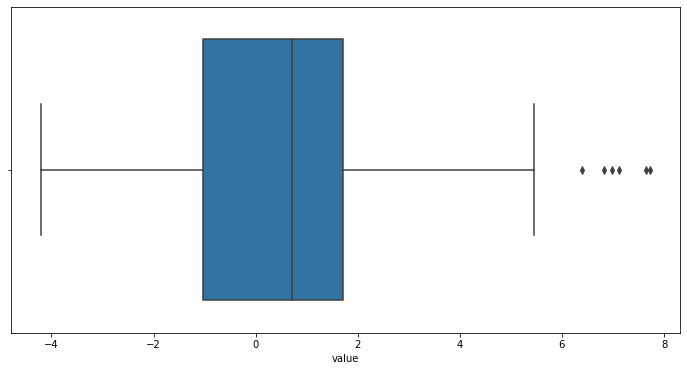

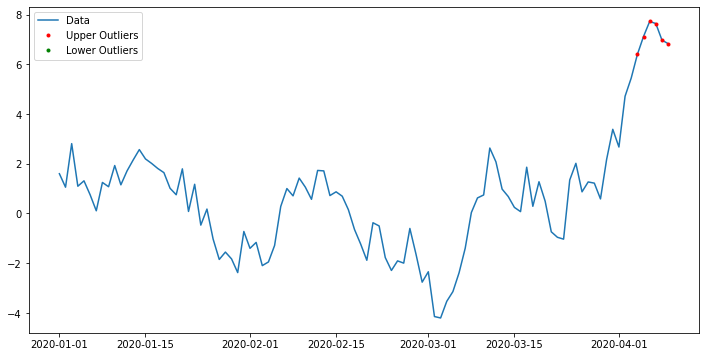

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 예를 들어, 다음과 같은 형태의 데이터가 있다고 가정합니다:
# DataFrame 'df' with columns 'date' and 'value'
df = pd.DataFrame({
    'date': pd.date_range(start='1/1/2020', periods=100),
    'value': np.random.randn(100).cumsum()
})

# Boxplot 생성
plt.figure(figsize=(12,6))
sns.boxplot(df['value'])
plt.show()

# IQR을 사용하여 이상치를 계산
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1

# 이상치를 표시하기 위한 불린 인덱스 생성
outliers_upper = df['value'] > (Q3 + 1.5 * IQR)
outliers_lower = df['value'] < (Q1 - 1.5 * IQR)

# 시계열 그래프에 이상치 표시
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['value'], label='Data')
plt.plot(df['date'][outliers_upper], df['value'][outliers_upper], 'r.', label='Upper Outliers')  # 상위 이상치는 빨간색 점으로 표시
plt.plot(df['date'][outliers_lower], df['value'][outliers_lower], 'g.', label='Lower Outliers')  # 하위 이상치는 초록색 점으로 표시
plt.legend()
plt.show()
